# Inject a SGWB into real data

This notebook is meant as a tutorial on how to use the `simulator` module within `pygwb` to generate a stochastic gravitational-wave background (SGWB), with the option of adding random Gaussian colored noise. More information about the `simulator` can be found on the documentation page [here](./_build/html/api/pygwb.simulator.html).

We start by importing some packages needed for the execution of the tutorial:

In [1]:
import numpy as np
import gwpy
import bilby
import matplotlib.pyplot as plt
%matplotlib inline
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
import gwpy.timeseries

*Note: make sure to run this notebook within an environment that has all the above packages installed.*

## Injection of a broken power-law 

For this tutorial, we consider a broken power-law signal power-spectral density (PSD) to be injected in real LIGO data. The various steps to get to the simulated data are outlined below.

### The signal to inject

The `simulator` module takes a `gwpy` FrequencySeries as input for the signal PSD to be injected. We start by building a custom input signal by defining an `IntensityGW` function, which outputs the desired signal PSD in the form of a `gwpy` FrequencySeries. 

In [2]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 1.e-4

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

Below, we show the signal PSD to be injected, corresponding to the parameter choice above.

Text(0, 0.5, 'Signal PSD')

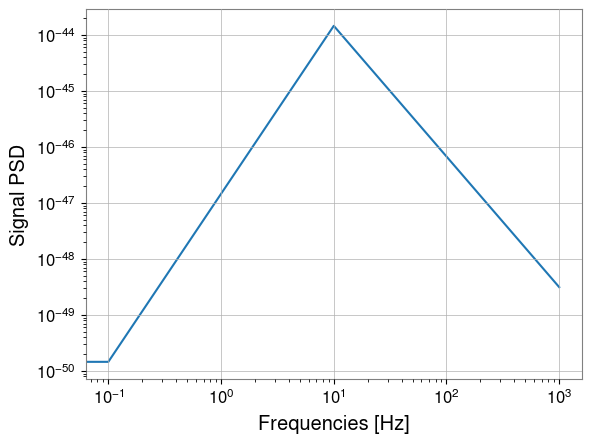

In [3]:
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Signal PSD')

Note that the above signal PSD was chosen for illustrative purposes. However, in practice, any signal PSD can be chosen to be injected, and one does not need to restrict themselves to a broken power-law.

### Create a network of interferometers

For this tutorial, we show an alternative way instantiating detectors, by using the `parameters` module. This allows to load the parameters, including the GPS times used to retrieve real data.

In [4]:
params = Parameters()
params.update_from_file(path="../test/test_data/parameters_baseline_test.ini")
params.t0=1247644204
params.tf=1247645100
params.segment_duration=128

We now create the two `interferometer` objects that will be used for the data simulation (LIGO Hanford (H1) and LIGO Livingston (L1) for this concrete example).

In [5]:
H1 = Interferometer.from_parameters(params.interferometer_list[0], params)
L1 = Interferometer.from_parameters(params.interferometer_list[1], params)

ifo_list = [H1, L1]

Note that the interferometers above contain the desired data in which we want to inject the signal. Indeed, if we plot part of the data, we see that there is data present in the detector object:

Text(0, 0.5, 'Strain')

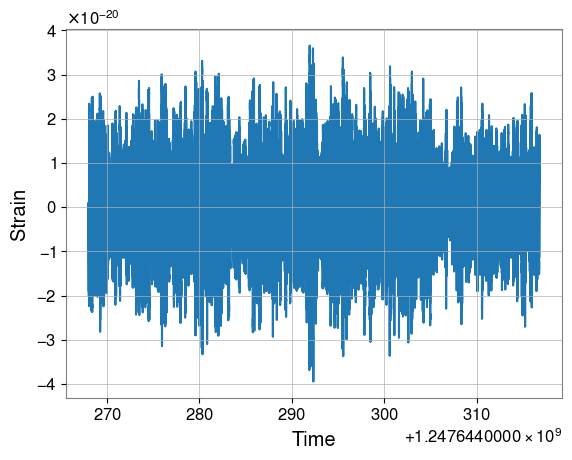

In [6]:
plt.plot(H1.timeseries.times[:100000], H1.timeseries.value[:100000])
plt.xlabel('Time')
plt.ylabel('Strain')

We now make sure the duration and sampling frequency of the detector is set to the desired value of these parameters as specified in the `parameters` object defined at the start of this notebook, and make sure the real data is set as the strain data in the interferometer.

In [7]:
for ifo in ifo_list:
    ifo.sampling_frequency = params.new_sample_rate
    ifo.set_strain_data_from_gwpy_timeseries(gwpy.timeseries.TimeSeries(data=ifo.timeseries.value, times=ifo.timeseries.times))
    ifo.duration=params.segment_duration

### Create baseline and network

Although the `simulator` module can be called directly, it is useful to rely on the `network` module and call the dedicated methods of that module (which calls the `simulator` behind the screens). We therefore start by creating a baseline of two detectors, which we then use to create a network of detectors.

In [8]:
HL_baseline = Baseline.from_parameters(H1, L1, params)

In [9]:
net_HL = Network.from_baselines("HL_network", [HL_baseline])

To ensure the above steps completed succesfully, we plot the first minute of data in the H1 detector in the time domain and the PSD in the frequency domain.

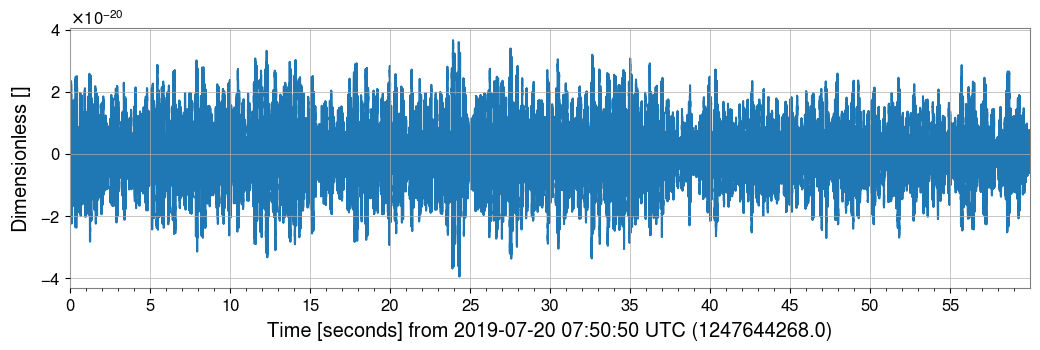

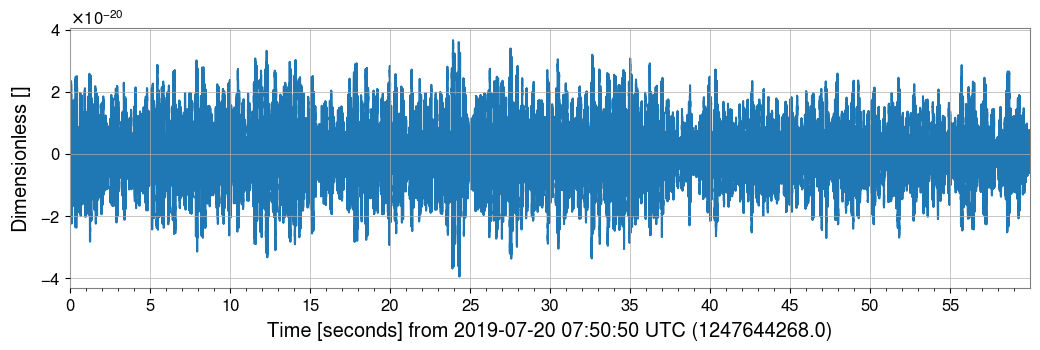

In [10]:
crop_start_time = net_HL.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min_pre_injection = net_HL.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min_pre_injection.plot()

Text(0, 0.5, 'PSD')

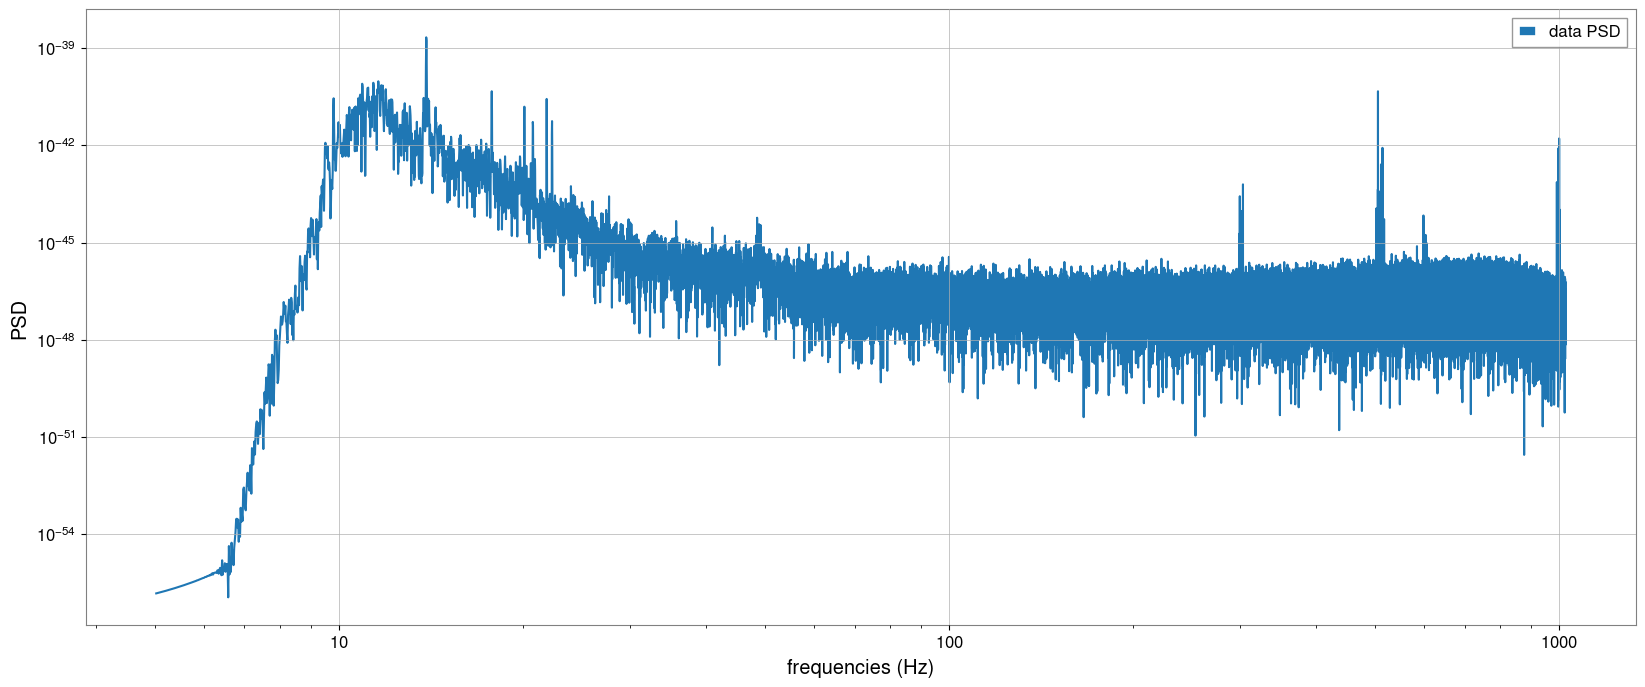

In [11]:
frequencies = data_H_1min_pre_injection.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min_pre_injection.psd().value[mask], label = 'data PSD')
plt.legend()
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')

### Inject simulated data on top of the real data

We are now ready to simulate the data, consisting of a signal injected in real detector data. We rely on the `network` module to simulate the data by calling the `set_interferometer_data_from_simulator` method (which uses the `simulator` module).

In [12]:
net_HL.set_interferometer_data_from_simulator(N_segments=7, GWB_intensity=Intensity_GW_inject, sampling_frequency=H1.sampling_frequency, inject_into_data_flag=True)

2023-05-23 03:58:03.716 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel H1:SIM-STOCH_INJ
2023-05-23 03:58:03.878 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel L1:SIM-STOCH_INJ


Note that the `inject_into_data_flag` is set to `True`, indicating the data will be injected in real data, and that additional Gaussian colored therefore does not need to be simulated.

In order to visualize part of the simulated data, we show the first minute of data for the H1 detector.

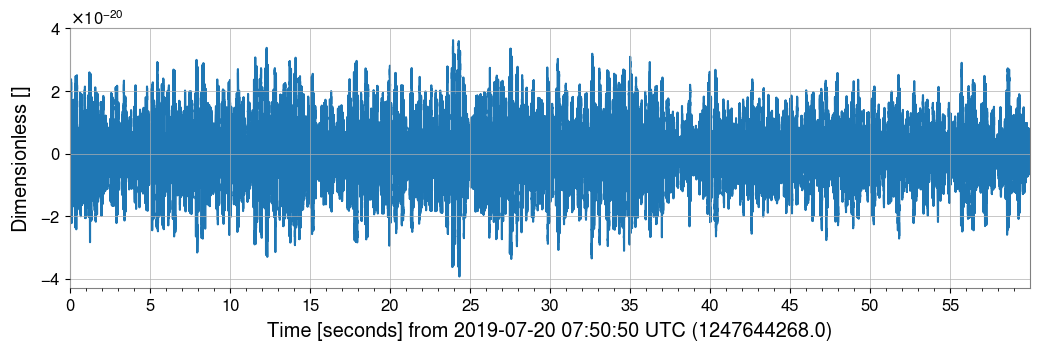

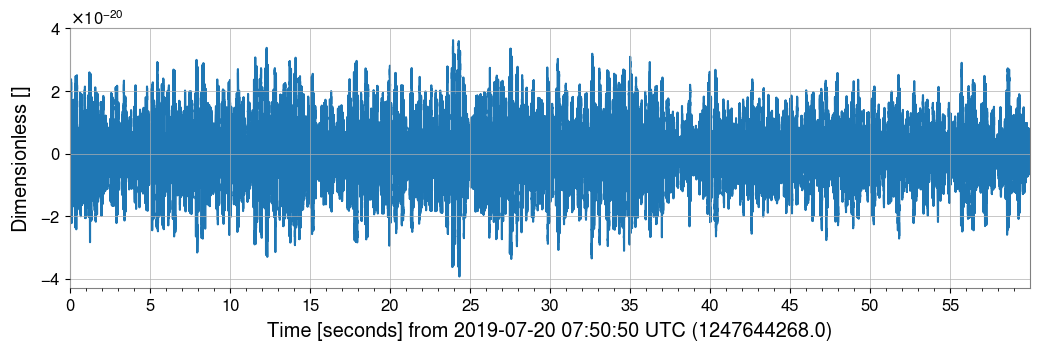

In [13]:
crop_start_time = net_HL.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min_post_injection = net_HL.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min_post_injection.plot()

*Optional*: Note that one may save the data by calling `save_interferometer_data_to_file` and specifying the file format as an argument. This wraps `gwpy.TimeSeries.write()`.

In [14]:
# net_HL.save_interferometer_data_to_file()

### Visualize the data PSD, both before and after the injection on top of real data

To conclude this tutorial, we look at the PSD of the data (instead of the time domain data shown above). For concreteness, we look at the one minute of H1 data plotted above.

Text(0, 0.5, 'PSD')

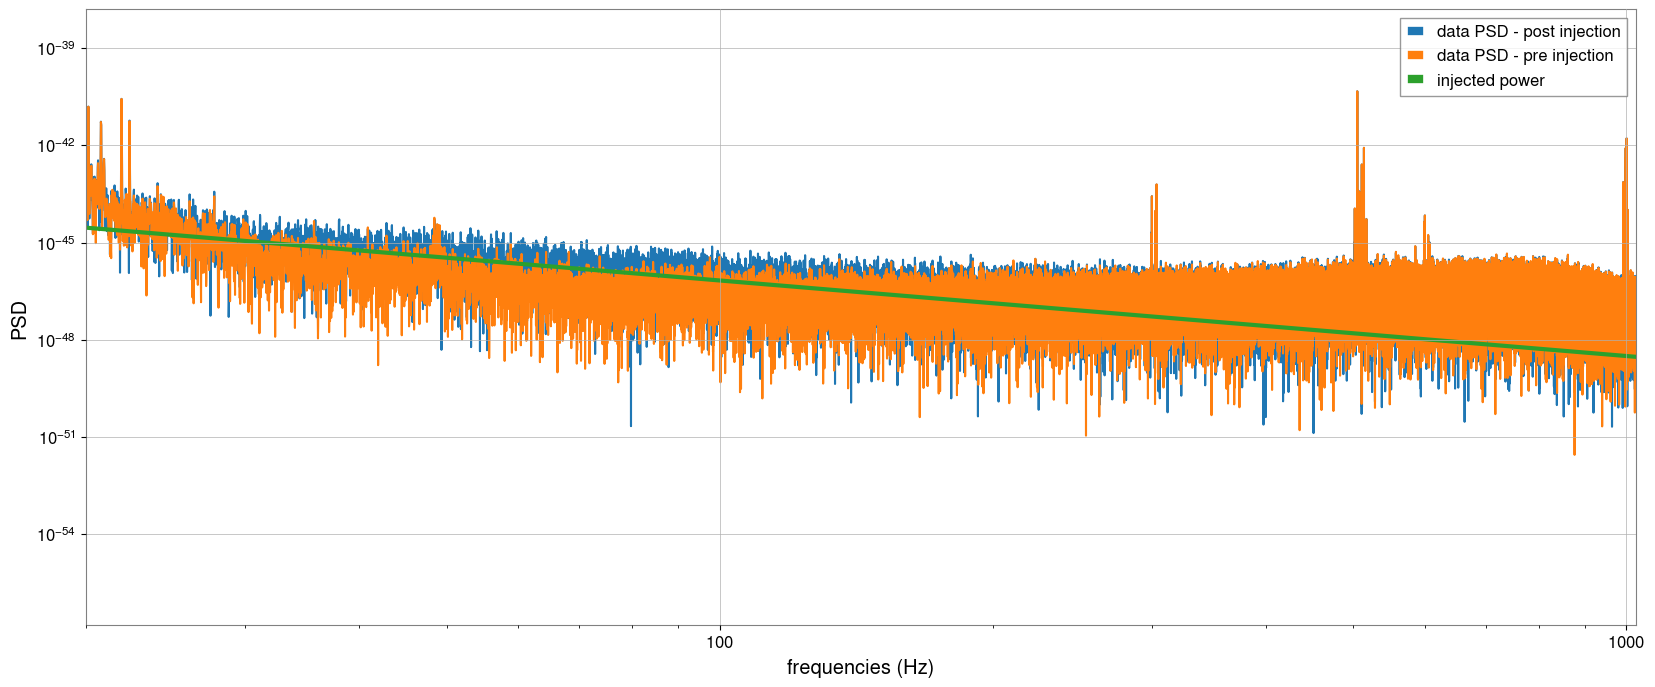

In [15]:
frequencies = data_H_1min_post_injection.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min_post_injection.psd().value[mask], label = 'data PSD - post injection')
plt.loglog(frequencies[mask], data_H_1min_pre_injection.psd().value[mask], label = 'data PSD - pre injection')


plt.loglog(frequencies[mask], IntensityGW(frequencies[mask],omegaRef = omegaRef, alpha1 = alpha1, fref = fref), linewidth = 3, label = 'injected power')
plt.legend()
plt.xlim(20,frequencies[-1])
plt.xlabel('frequencies (Hz)')
plt.ylabel('PSD')

The above plot shows the PSD of the data before (orange) and after (blue) the injection of the signal, together with the desired signal PSD (green). One can see that the data PSD rises and follows the signal PSD after the signal was injected, illustrating the injection was performed correctly, and the signal is actually present in the data.